In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import gudhi as gd
import gudhi.hera as hera
from gudhi.wasserstein import wasserstein_distance
import torch
import torch.nn as nn
torch.set_default_dtype(torch.float64)
inf = float('inf')

## CODING PROCESS

Robustness of a classifier $f$:
- Crafting adversarial examples
- Certifying Networks
- Robust-NN by construction

Focus:
> TDA focused on Stability/Lipschitzness

Classification Process:

0) INPUT = Point Cloud {generation of the dataset}
1) From Point Cloud to Simpicial Complex {GUDHI; Alpha-Complexes}
2) From Simplicial Complex to Persistence Module {GUDHI; Stability results}
3) From Persistence Module to Vectorization {Pers Image, StableRanks; Stability results}
4) From vectorization to (NN!) Predicted Class {FC-NN, PersLay, $L_\infty$-dist Net, ...}


$\it{Lipschitz}$ constant of a FC NN is too large usually => less robust at test time

PersLay: implicit vectorization and permutation invariant thanks to a specific layer



> CONTINUITY
- Generating Persistences from point clouds and compute distances for each pair of persistence diagrams: Wasserstein distance from GUDHI (correct p, hera.wasserstein_distance)
- Transformation of Persistence Diagram with StableRanks and compute $L_p$ distance among pairs of 'vectorization' ('Interleaving distance', using $L_\infty$ distance)
- NN elaboration of StableRanks ($L_\infty$ distance)

> H0 and H1 separated! (Martina + Andrea G)

NN for H0 and one for H1 / NN for both

DISTANCES for H0 and one for H1 / DISTANCES for both

3 sets of INPUT for NNs:
- H0 + H1: concat persistences; 
    - Wassestein H0,H0 and H1,H1 $W_0, W_1$
    - StableRanks $S_0,S_1$
    - Embeddings: $E$ {they can be }

    $\frac{E}{S_0}$ fir Lip, component <1
    $\frac{S_0}{W_0}$ fir Lip, component <1
    $\frac{E}{S_1}$ fir Lip, component <1
    $\frac{S_1}{W_1}$ fir Lip, component <1

- H0 only:
    - Wassestein H0,H0 $W_0$
    - StableRanks $S_0$
    - Embeddings $E_0$

    $\frac{E_0}{S_0}$ fir Lip, component <1
    $\frac{S_0}{W_0}$ fir Lip, component <1

- H1 only:

    - Wassestein H1,H1 $W_1$
    - StableRanks $S_1$
    - Embeddings $E_1$

    $\frac{E_1}{S_1}$ fir Lip, component <1
    $\frac{S_1}{W_1}$ fir Lip, component <1

For now: just the lengths (basic StableRanks)
For after: Robustness radius, Contours and others

Checking H1

(NN for H0,) NN for H1: H1 is better 

Adversarial example: change one/some bars in a barcode and compute pers, SR and NN output

Lipschitz property, Radius, Margin: try to relate them to distaces

Extra: sum of distances for concatenation...

> CREATE THE DATASET AND SORT PERSISTENCES

In [16]:
def generate_Datasets(n_points_per_orbit = 1000, params = [2.5, 3.5, 4.0, 4.1, 4.3], size_dataset = [700,300]):
    # TRAIN
    train_dataset = np.zeros([size_dataset[0]*len(params), n_points_per_orbit, 2])
    for num_p, r in enumerate(params): # one class at the time
        for n_orb in range(size_dataset[0]): # all point clouds for each class
            id_orb = n_orb + num_p*size_dataset[0]
            xcur, ycur = np.random.rand(), np.random.rand() # init the first value for cloud computation
            for id_pt in range(n_points_per_orbit):
                xcur = (xcur + r * ycur * (1. - ycur)) % 1
                ycur = (ycur + r * xcur * (1. - xcur)) % 1
                train_dataset[id_orb, id_pt, :] = [xcur, ycur] # save the [x,y] point of the cloud
    train_labels = np.array([0]*size_dataset[0]+\
                            [1]*size_dataset[0]+\
                            [2]*size_dataset[0]+\
                            [3]*size_dataset[0]+\
                            [4]*size_dataset[0])
    # TEST
    test_dataset = np.zeros([size_dataset[1]*len(params), n_points_per_orbit, 2])
    for num_p, r in enumerate(params): # one class at the time
        for n_orb in range(size_dataset[1]): # all point clouds for each class
            id_orb = n_orb + num_p*size_dataset[1]
            xcur, ycur = np.random.rand(), np.random.rand() # init the first value for cloud computation
            for id_pt in range(n_points_per_orbit):
                xcur = (xcur + r * ycur * (1. - ycur)) % 1
                ycur = (ycur + r * xcur * (1. - xcur)) % 1
                test_dataset[id_orb, id_pt, :] = [xcur, ycur] # save the [x,y] point of the cloud
    test_labels = np.array([0]*size_dataset[1]+\
                            [1]*size_dataset[1]+\
                            [2]*size_dataset[1]+\
                            [3]*size_dataset[1]+\
                            [4]*size_dataset[1])
    return train_dataset, train_labels, test_dataset, test_labels

train_data, train_lab, test_data, test_lab = generate_Datasets(size_dataset = [700,80])

In [17]:
def get_persistences(train_clouds, test_clouds):

    train_persistences = []
    L = train_clouds.shape[0]
    for i in tqdm(range(L), desc = 'TRAIN PERS '):
        ac = gd.AlphaComplex(points=train_clouds[i,:,:])
        st = ac.create_simplex_tree()
        pers = st.persistence() # need to be run even if I won't use it
        pers_0 = np.array(st.persistence_intervals_in_dimension(0)).transpose()[:,:-1]
        lengths_0 = pers_0[1] - pers_0[0]
        sorted_indices_desc_0 = np.argsort(-lengths_0)
        sorted_pers_0 = pers_0[:,sorted_indices_desc_0]*1000
        
        pers_1 = np.array(st.persistence_intervals_in_dimension(1)).transpose()
        lengths_1 = pers_1[1] - pers_1[0]
        sorted_indices_desc_1 = np.argsort(-lengths_1)
        sorted_pers_1 = pers_1[:,sorted_indices_desc_1]*1000

        pers_dict = {
            'pers_0': sorted_pers_0,
            'pers_1': sorted_pers_1
        }
        train_persistences.append(pers_dict)
    
    test_persistences = []
    L = test_clouds.shape[0]
    for i in tqdm(range(L), desc = 'TEST PERS '):
        ac = gd.AlphaComplex(points=test_clouds[i,:,:])
        st = ac.create_simplex_tree()
        pers = st.persistence()
        pers_0 = np.array(st.persistence_intervals_in_dimension(0)).transpose()[:,:-1]
        lengths_0 = pers_0[1] - pers_0[0]
        sorted_indices_desc_0 = np.argsort(-lengths_0) #Get the indices that would sort the lengths array
        sorted_pers_0 = pers_0[:,sorted_indices_desc_0]*1000
        
        pers_1 = np.array(st.persistence_intervals_in_dimension(1)).transpose()
        lengths_1 = pers_1[1] - pers_1[0]
        sorted_indices_desc_1 = np.argsort(-lengths_1)
        sorted_pers_1 = pers_1[:,sorted_indices_desc_1]*1000

        pers_dict = {
            'pers_0': sorted_pers_0,
            'pers_1': sorted_pers_1
        }
        test_persistences.append(pers_dict)
    
    return train_persistences, test_persistences

train_pers, test_pers = get_persistences(train_data, test_data)

TEST PERS : 100%|██████████| 400/400 [00:11<00:00, 34.03it/s]


In [18]:
# values about persistences without and with rescaling
train_pers[0]['pers_1'], \
train_pers[0]['pers_1']/1000

(array([[0.62365205, 0.99125408, 0.46282464, ..., 0.39247228, 0.21684718,
         0.39948764],
        [8.42797734, 6.08016799, 2.59495619, ..., 0.39247269, 0.21684756,
         0.39948773]]),
 array([[0.00062365, 0.00099125, 0.00046282, ..., 0.00039247, 0.00021685,
         0.00039949],
        [0.00842798, 0.00608017, 0.00259496, ..., 0.00039247, 0.00021685,
         0.00039949]]))

Now I have ordered persistences H0 and H1, contained in arrays of dicts!

I need to resize the length of each array: I coudn't do it before because I don't want to compute persistences all the time I change the size I want for my arrays. 

After that I can compute distances and stableranks!

In [19]:
preproc_size = 300

train_preproc_H0 = np.array([train_pers[i]['pers_0'][:,:preproc_size] for i in range(len(train_pers))])
test_preproc_H0 = np.array([test_pers[i]['pers_0'][:,:preproc_size] for i in range(len(test_pers))])

train_preproc_H1 = []
for i in range(len(train_pers)):
    pers_H1 = train_pers[i]['pers_1']
    current_length = pers_H1.shape[1]
    
    if current_length >= preproc_size:
        adjusted_array = pers_H1[:,:preproc_size]
    elif current_length < preproc_size:
        pad_width = preproc_size - current_length
        adjusted_array = np.pad(pers_H1, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    train_preproc_H1.append(adjusted_array)
train_preproc_H1 = np.array(train_preproc_H1)

test_preproc_H1 = []
for i in range(len(test_pers)):
    pers_H1 = test_pers[i]['pers_1']
    current_length = pers_H1.shape[1]
    
    if current_length >= preproc_size:
        adjusted_array = pers_H1[:,:preproc_size]
    elif current_length < preproc_size:
        pad_width = preproc_size - current_length
        adjusted_array = np.pad(pers_H1, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    test_preproc_H1.append(adjusted_array)
test_preproc_H1 = np.array(test_preproc_H1)

In [20]:
train_preproc_H0.shape, test_preproc_H0.shape, train_preproc_H1.shape, test_preproc_H1.shape

((3500, 2, 300), (400, 2, 300), (3500, 2, 300), (400, 2, 300))

> WASSERSTEIN DISTANCES

In [21]:
test_size = test_preproc_H0.shape[0]
H0_pers_distances = np.zeros((test_size, test_size))
H1_pers_distances = np.zeros((test_size, test_size))

p = 6

# for i in range(test_size):
for i in tqdm(range(test_size),desc = f'WASSERSTEIN DISTANCES with p = {p}'): # 2 mins each one....
    diag_H0_i = test_preproc_H0[i,:,:].transpose()
    diag_H1_i = test_preproc_H1[i,:,:].transpose()
    # for j in tqdm(range(i,test_size)):
    for j in range(i,test_size):
        diag_H0_j = test_preproc_H0[j,:,:].transpose()
        diag_H1_j = test_preproc_H1[j,:,:].transpose()
        # save distances in matrices
        dist_H0 = hera.wasserstein_distance(diag_H0_i, diag_H0_j, matching=False, order=p, internal_p=1)
        dist_H1 = hera.wasserstein_distance(diag_H1_i, diag_H1_j, matching=False, order=p, internal_p=1)
        H0_pers_distances[i,j] = dist_H0
        H0_pers_distances[j,i] = dist_H0
        H1_pers_distances[i,j] = dist_H1
        H1_pers_distances[j,i] = dist_H1

WASSERSTEIN DISTANCES with p = 6: 100%|██████████| 400/400 [4:05:02<00:00, 36.76s/it]  


In [22]:
import pickle; saving_name = './wass_dist_fixed'
saving_dict = {
    'H0_dist_pers': H0_pers_distances,
    'H1_dist_pers': H1_pers_distances,
    
    'original_train_data': train_data,
    'train_lab': train_lab,
    'train_H0_preproc': train_preproc_H0,
    'train_H1_preproc': train_preproc_H1,

    'original_test_data': test_data,
    'test_lab': test_lab,
    'test_H0_preproc': test_preproc_H0,
    'test_H1_preproc': test_preproc_H1
}

# Save data to a pickle file
with open(saving_name, 'wb') as file:
    pickle.dump(saving_dict, file)

print(f"Data has been saved to {saving_name}")



Data has been saved to ./wass_dist_fixed


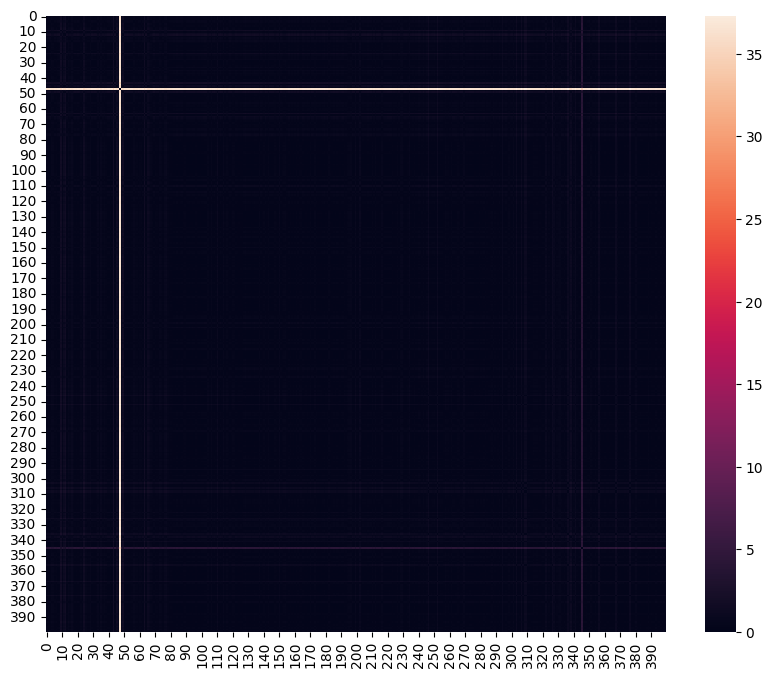

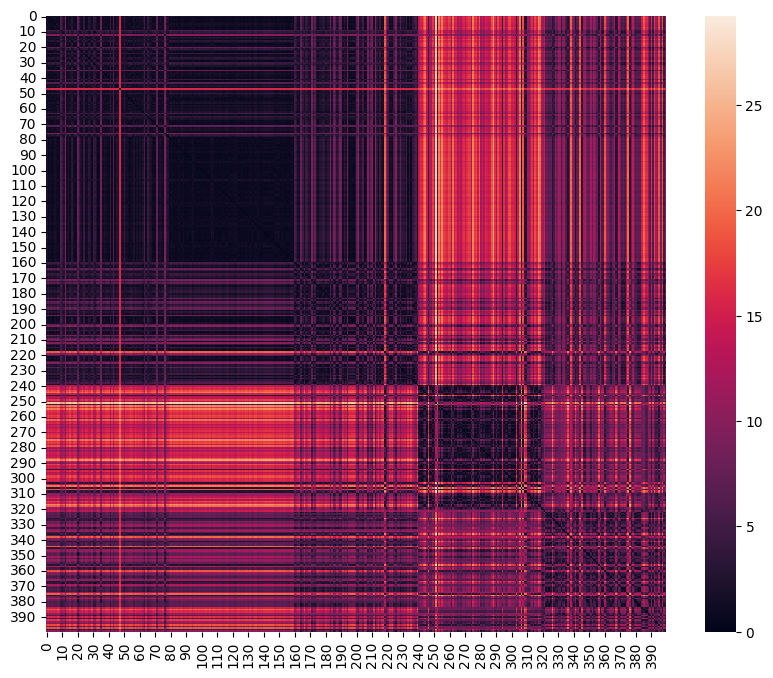

In [23]:
plt.figure(figsize=(10,8))
sns.heatmap(H0_pers_distances)
plt.show()
plt.figure(figsize=(10,8))
sns.heatmap(H1_pers_distances)
plt.show()

> STABLE RANKS

In [24]:
stableranks_dict = {
    'train_H0': [],
    'train_H1': [],
    'test_H0': [],
    'test_H1': []
}
for key, dat in zip(stableranks_dict.keys(), [train_preproc_H0, train_preproc_H1, test_preproc_H0, test_preproc_H1]):
    stableranks_dict[key] = np.array([dat[i,1,:] - dat[i,0,:] for i in range(dat.shape[0])])


In [25]:
stableranks_dict['train_H1'].shape

(3500, 300)

In [26]:
# means and std of training
mean_train_H0 = np.mean(stableranks_dict['train_H0'], axis=0)
std_train_H0 = np.std(stableranks_dict['train_H0'], axis=0)
mean_train_H1 = np.mean(stableranks_dict['train_H1'], axis=0)
std_train_H1 = np.std(stableranks_dict['train_H1'], axis=0)
std_train_H0.shape

(300,)

In [27]:
# check about means and std between train and test
mean_train_H0 = np.mean(stableranks_dict['train_H0'], axis=0)
std_train_H0 = np.std(stableranks_dict['train_H0'], axis=0)
mean_train_H1 = np.mean(stableranks_dict['train_H1'], axis=0)
std_train_H1 = np.std(stableranks_dict['train_H1'], axis=0)

mean_test_H0 = np.mean(stableranks_dict['test_H0'], axis=0)
std_test_H0 = np.std(stableranks_dict['test_H0'], axis=0)
mean_test_H1 = np.mean(stableranks_dict['test_H1'], axis=0)
std_test_H1 = np.std(stableranks_dict['test_H1'], axis=0)

# H0
print(f'{mean_train_H0.mean() = } - {mean_test_H0.mean() = }')
print(f'{std_train_H0.mean() = } - {std_test_H0.mean() = }')
# H1
print(f'{mean_train_H1.mean() = } - {mean_test_H1.mean() = }')
print(f'{std_train_H1.mean() = } - {std_test_H1.mean() = }')

mean_train_H0.mean() = 0.2620613820222319 - mean_test_H0.mean() = 0.25905742435993656
std_train_H0.mean() = 0.052836351633359 - std_test_H0.mean() = 0.07665310903306874
mean_train_H1.mean() = 0.33235497116767154 - mean_test_H1.mean() = 0.3265093241475557
std_train_H1.mean() = 0.08490806697868558 - std_test_H1.mean() = 0.09586499550080374


> DISTANCES AMONG STABLE RANKS using $L_\infty$ distance

In [28]:
H0_SR_distances = np.zeros((test_size, test_size))
H1_SR_distances = np.zeros((test_size, test_size))

# for i in range(test_size):
for i in tqdm(range(test_size),desc = f'L_\infty DISTANCES among STABLE RANKS'): # 2 mins each one....
    sr_H0_i = stableranks_dict['test_H0'][i,:].transpose()
    sr_H1_i = stableranks_dict['test_H1'][i,:].transpose()
    # for j in tqdm(range(test_size)):
    for j in range(test_size):
        sr_H0_j = stableranks_dict['test_H0'][j,:].transpose()
        sr_H1_j = stableranks_dict['test_H1'][j,:].transpose()
        # L_infty distance!
        H0_SR_distances[i,j] = np.max(np.abs(sr_H0_i - sr_H0_j))
        H1_SR_distances[i,j] = np.max(np.abs(sr_H1_i - sr_H1_j))

L_\infty DISTANCES among STABLE RANKS: 100%|██████████| 400/400 [00:01<00:00, 313.50it/s]


In [29]:
result_SW0 = np.divide(H0_SR_distances, H0_pers_distances)
result_SW1 = np.divide(H1_SR_distances, H1_pers_distances)
mask0 = result_SW0 >= 1
mask1 = result_SW1 >= 1
positions0 = np.argwhere(mask0)
positions1 = np.argwhere(mask1)
len(positions0), len(positions1)

/tmp/ipykernel_1369/2808171542.py:1: RuntimeWarning: invalid value encountered in divide
  result_SW0 = np.divide(H0_SR_distances, H0_pers_distances)
/tmp/ipykernel_1369/2808171542.py:2: RuntimeWarning: invalid value encountered in divide
  result_SW1 = np.divide(H1_SR_distances, H1_pers_distances)


(0, 20)

Distanze minori di 2?

Bottleneck(x,y)>= 1/2 * L_inf(SRx, SRy)

Fissando (i,j) check delle distanze che diminuiscono

Plot:
- x: distanze ordinate dalla più piccola alla più grande con bottleneck
- y: quanto è diminuita, ovvero d_pers - d_SR o quoziente
> Distanze grandi per d_pers diventano più piccole maggiormente

Distribuzione delle distanze



> NN to classify StableRanks

Batching StableRanks and merge with the proper labels

Batching only training data, test are computed all together

In [30]:
from sklearn.utils import shuffle

a_shuffled, b_shuffled, labs_sf = shuffle(stableranks_dict['train_H0'], stableranks_dict['train_H1'], train_lab)

In [31]:
c = list(zip(stableranks_dict['train_H0'], stableranks_dict['train_H1'], train_lab))

random.shuffle(c)

a, b, d = zip(*c)

NameError: name 'random' is not defined

In [ ]:
from random import shuffle
# SHUFFLING EXAMPLE
# x = [[i] for i in range(10)]
# shuffle(x)

data_len = stableranks_dict['train_H0'].shape[0]
train_data = [[stableranks_dict['train_H0'][i], stableranks_dict['train_H1'][i], train_lab[i]] for i in range(data_len)]
# shuffle(train_data)
indexes = np.arange(data_len)
shuffle(indexes)

batch_size = 128
indexes
# n_batches = data_len//batch_size +1
# batched_train = []
# for i in range(n_batches):
#     batched_train.sppend(
        

#     )

array([3446, 1481, 3216, ...,  100, 2922, 3499])

In [ ]:
# stableranks_dict['train_H0'], ..., train_lab, test_lab
batch_size = 128
L = stableranks_dict['train_H0'].shape[0]
n_batches = L//batch_size +1
batched_train = []
for i in range(n_batches):
    batched_train.append(\
        [torch.tensor(stableranks_dict['train_H0'][i*batch_size:(i+1)*batch_size,:]),\
        torch.tensor(stableranks_dict['train_H1'][i*batch_size:(i+1)*batch_size,:]),\
        torch.tensor(train_lab[i*batch_size:(i+1)*batch_size])])

In [ ]:
test_ds = [[torch.tensor(stableranks_dict['test_H0']),\
            torch.tensor(stableranks_dict['test_H1']),\
            torch.tensor(test_lab)]]

$L_\infty$ Layers and Network to classify stableranks

Normalization for the first layer?

In [ ]:
class linfLayer(nn.Module):
    def __init__(self, in_blocks, out_blocks, scaling = []):
        super().__init__()
        
        if len(scaling)==2:
            params = torch.randn((out_blocks, in_blocks)) * scaling[1] + scaling[0] # random*std + mean
            self.params = torch.nn.Parameter(data=params)
        elif len(scaling)==1:
            params = torch.randn((out_blocks, in_blocks)) * scaling[0] # random*std
            self.params = torch.nn.Parameter(data=params)
        else:
            params = torch.randn((out_blocks, in_blocks)) # only random in gaussian(mean=0, std=1)
            self.params = torch.nn.Parameter(data=params)

        # params = torch.randn((out_blocks, in_blocks)) * 0.05
        # self.params = torch.nn.Parameter(data=params)

    def forward(self, x, p):
        res = torch.cdist(x, self.params, p=p) #torch.cdist but with custom params
        return res
    
class linfModel(nn.Module):
    def __init__(self, preproc_size, scaling_H0, scaling_H1):
        super().__init__()

        self.layer1_H0 = linfLayer(in_blocks=preproc_size, out_blocks=500)
        self.layer2_H0 = linfLayer(in_blocks=500, out_blocks=300)
        self.layer3_H0 = linfLayer(in_blocks=300, out_blocks=150)
        self.layer4_H0 = linfLayer(in_blocks=150, out_blocks=80)

        self.layer1_H1 = linfLayer(in_blocks=preproc_size, out_blocks=500)
        self.layer2_H1 = linfLayer(in_blocks=500, out_blocks=300)
        self.layer3_H1 = linfLayer(in_blocks=300, out_blocks=150)
        self.layer4_H1 = linfLayer(in_blocks=150, out_blocks=80)

        self.layer1_output = linfLayer(in_blocks=160, out_blocks=100)
        self.layer2_output = linfLayer(in_blocks=100, out_blocks=50)
        self.layer3_output = linfLayer(in_blocks=50, out_blocks=5)

    def forward(self, h0, h1, p):
        B = h0.shape[0]
        h0 = self.layer1_H0(h0, p)
        h0 = h0 - h0.mean(axis=0)
        h0 = self.layer2_H0(h0, p)
        h0 = h0 - h0.mean(axis=0)
        h0 = self.layer3_H0(h0, p)
        h0 = h0 - h0.mean(axis=0)
        h0 = self.layer4_H0(h0, p)
        
        h1 = self.layer1_H1(h1, p)
        h1 = h1 - h1.mean(axis=0)
        h1 = self.layer2_H1(h1, p)
        h1 = h1 - h1.mean(axis=0)
        h1 = self.layer3_H1(h1, p)
        h1 = h1 - h1.mean(axis=0)
        h1 = self.layer4_H1(h1, p)

        concat = torch.cat((h0.view(B, -1), h1.view(B, -1)), dim = 1)
        output = self.layer1_output(concat, p)
        output = output - output.mean(axis=0)
        output = self.layer2_output(output, p)
        output = output - output.mean(axis=0)
        output = self.layer3_output(output, p)
        return -output


NameError: name 'nn' is not defined

In [ ]:
epochs = 300
inf=float("inf")

p_schedule = np.ones(epochs)*inf

# e1, e2 = 20,40 # e1+e2 < epochs !!
# p_schedule = np.ones(epochs)*8
# p_schedule[e1:e1+e2] = np.linspace(8, 100, e2)
# p_schedule[e1+e2:] = inf

save_folder = f'./LinfModels/'

def test_model(model, test_data, if_plot):
    # Set the model to evaluation mode
    model.eval()

    target_labs = np.array([])
    pred_labs = np.array([])
    correct = 0
    total = 0

    # Disable gradient calculation
    with torch.no_grad():
        for h0, h1, cl in test_data:

            # Forward pass
            outputs = model(h0, h1, p_schedule[i])
            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)
            # Total number of labels
            total += cl.size(0)
            # Total correct predictions
            correct += (predicted == cl).sum().item()
            target_labs = np.append(target_labs, cl)
            pred_labs = np.append(pred_labs, predicted)

    # Calculate accuracy
    accuracy = 100 * correct / total
    # print('Accuracy on the test set: {:.2f}%'.format(accuracy))

    if if_plot:
        cm = confusion_matrix(np.array(target_labs), np.array(pred_labs))
        classes = [1,2,3,4,5]
        # Plot confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()
        
    return accuracy

In [ ]:
model = linfModel(preproc_size, scaling_H0=[mean_train_H0, std_train_H0], scaling_H1=[mean_train_H1, std_train_H1])
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.05, eps=1e-06)
# list(model.parameters())[0].shape
losses = []
best_acc = 0.0

for i in range(epochs):
    for (h0, h1, cl) in batched_train:
        model.train()
        tot_loss = 0.0
        
        #calculate output
        output = model(h0, h1, p_schedule[i])

        #calculate loss
        loss = loss_fn(output, cl.long())

        #backprop
        optimizer.zero_grad()
        tot_loss += float(loss)
        loss.backward()
        optimizer.step()
    
    losses.append(tot_loss)
    test_acc = test_model(model, test_ds, if_plot=False)
    if best_acc < test_acc:
        if test_acc > 80.0:
            torch.save(model.state_dict(), save_folder + f'PURE_{preproc_size}_acc_{test_acc:.3f}.pth')
        print(f'\rEpoch {i+1:3}/{epochs} --> IMPROVEMENT from {best_acc:.3f} to {test_acc:.3f} \t')
        best_acc = test_acc
    else:
        # print(f'> Test Accuracy = {test_acc} [best = {best_acc}]')
        print(f"\r Epoch {i+1:3}\tloss : {loss:.5f}, p: {p_schedule[i]}", end='')

plt.plot(np.array(losses))
train_acc = test_model(model, batched_train, if_plot=True)
test_acc = test_model(model, test_ds, if_plot=True)
train_acc, test_acc

Epoch   1/300 --> IMPROVEMENT from 0.000 to 18.667 	
Epoch   4/300 --> IMPROVEMENT from 18.667 to 28.000 	
 Epoch  52	loss : 0.64213, p: inf

KeyboardInterrupt: 

> NN's OUTPUT INSPECTION

Computation of $L_\infty$ distance between each pair of outputs computed by the model

In [ ]:
# # IF NEEDED!
# model_str = save_folder + 'PURE_750_acc_80.133.pth'
# saved_params = torch.load(model_str)
# model.load_state_dict(saved_params)

model.eval()
test_output = model(test_ds[0][0], test_ds[0][1], inf)
print(test_output.shape)
outNN_distances = torch.cdist(test_output, test_output, p=inf) # matrix[test_size, test_size] with all L_inf distaces

torch.Size([300, 5])


In [ ]:
# check Lip of NN wrt StableRanks
result_ES = np.divide(outNN_distances.detach().numpy(), H0_SR_distances)
mask = result_ES >= 1
positions = np.argwhere(mask)
len(positions)


/tmp/ipykernel_349/1621662599.py:2: RuntimeWarning: invalid value encountered in divide
  result_ES = np.divide(outNN_distances.detach().numpy(), H0_SR_distances)


86018

> MARGIN CHECK

Radius, scale of outputs, 

In [ ]:
output_sorted = torch.sort(test_output, dim=1, descending=True)[0]
margin = (output_sorted[:,0] - output_sorted[:,1])
margin.shape, (margin).mean()

(torch.Size([300]), tensor(0.7084, grad_fn=<MeanBackward0>))